In [100]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal


In [101]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [102]:
real_x=data.iloc[:,0:30].values
real_y=data.iloc[:,30].values

In [103]:
fraud=data[data["Class"]==1]
normal=data[data["Class"]==0]
freq_fraud=len(fraud)
freq_normal=len(normal)
#scaler=StandardScaler()
#real_x=scaler.fit_transform(real_x)

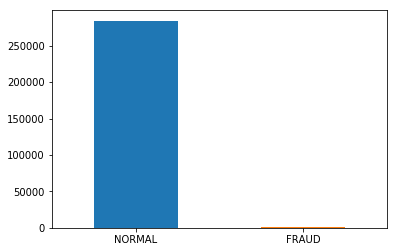

In [104]:
LABEL=["NORMAL","FRAUD"]
count_classes=pd.value_counts(data['Class']==1)
count_classes.plot(kind='bar',rot=0)
plt.xticks(range(0,2),LABEL)
plt.show()

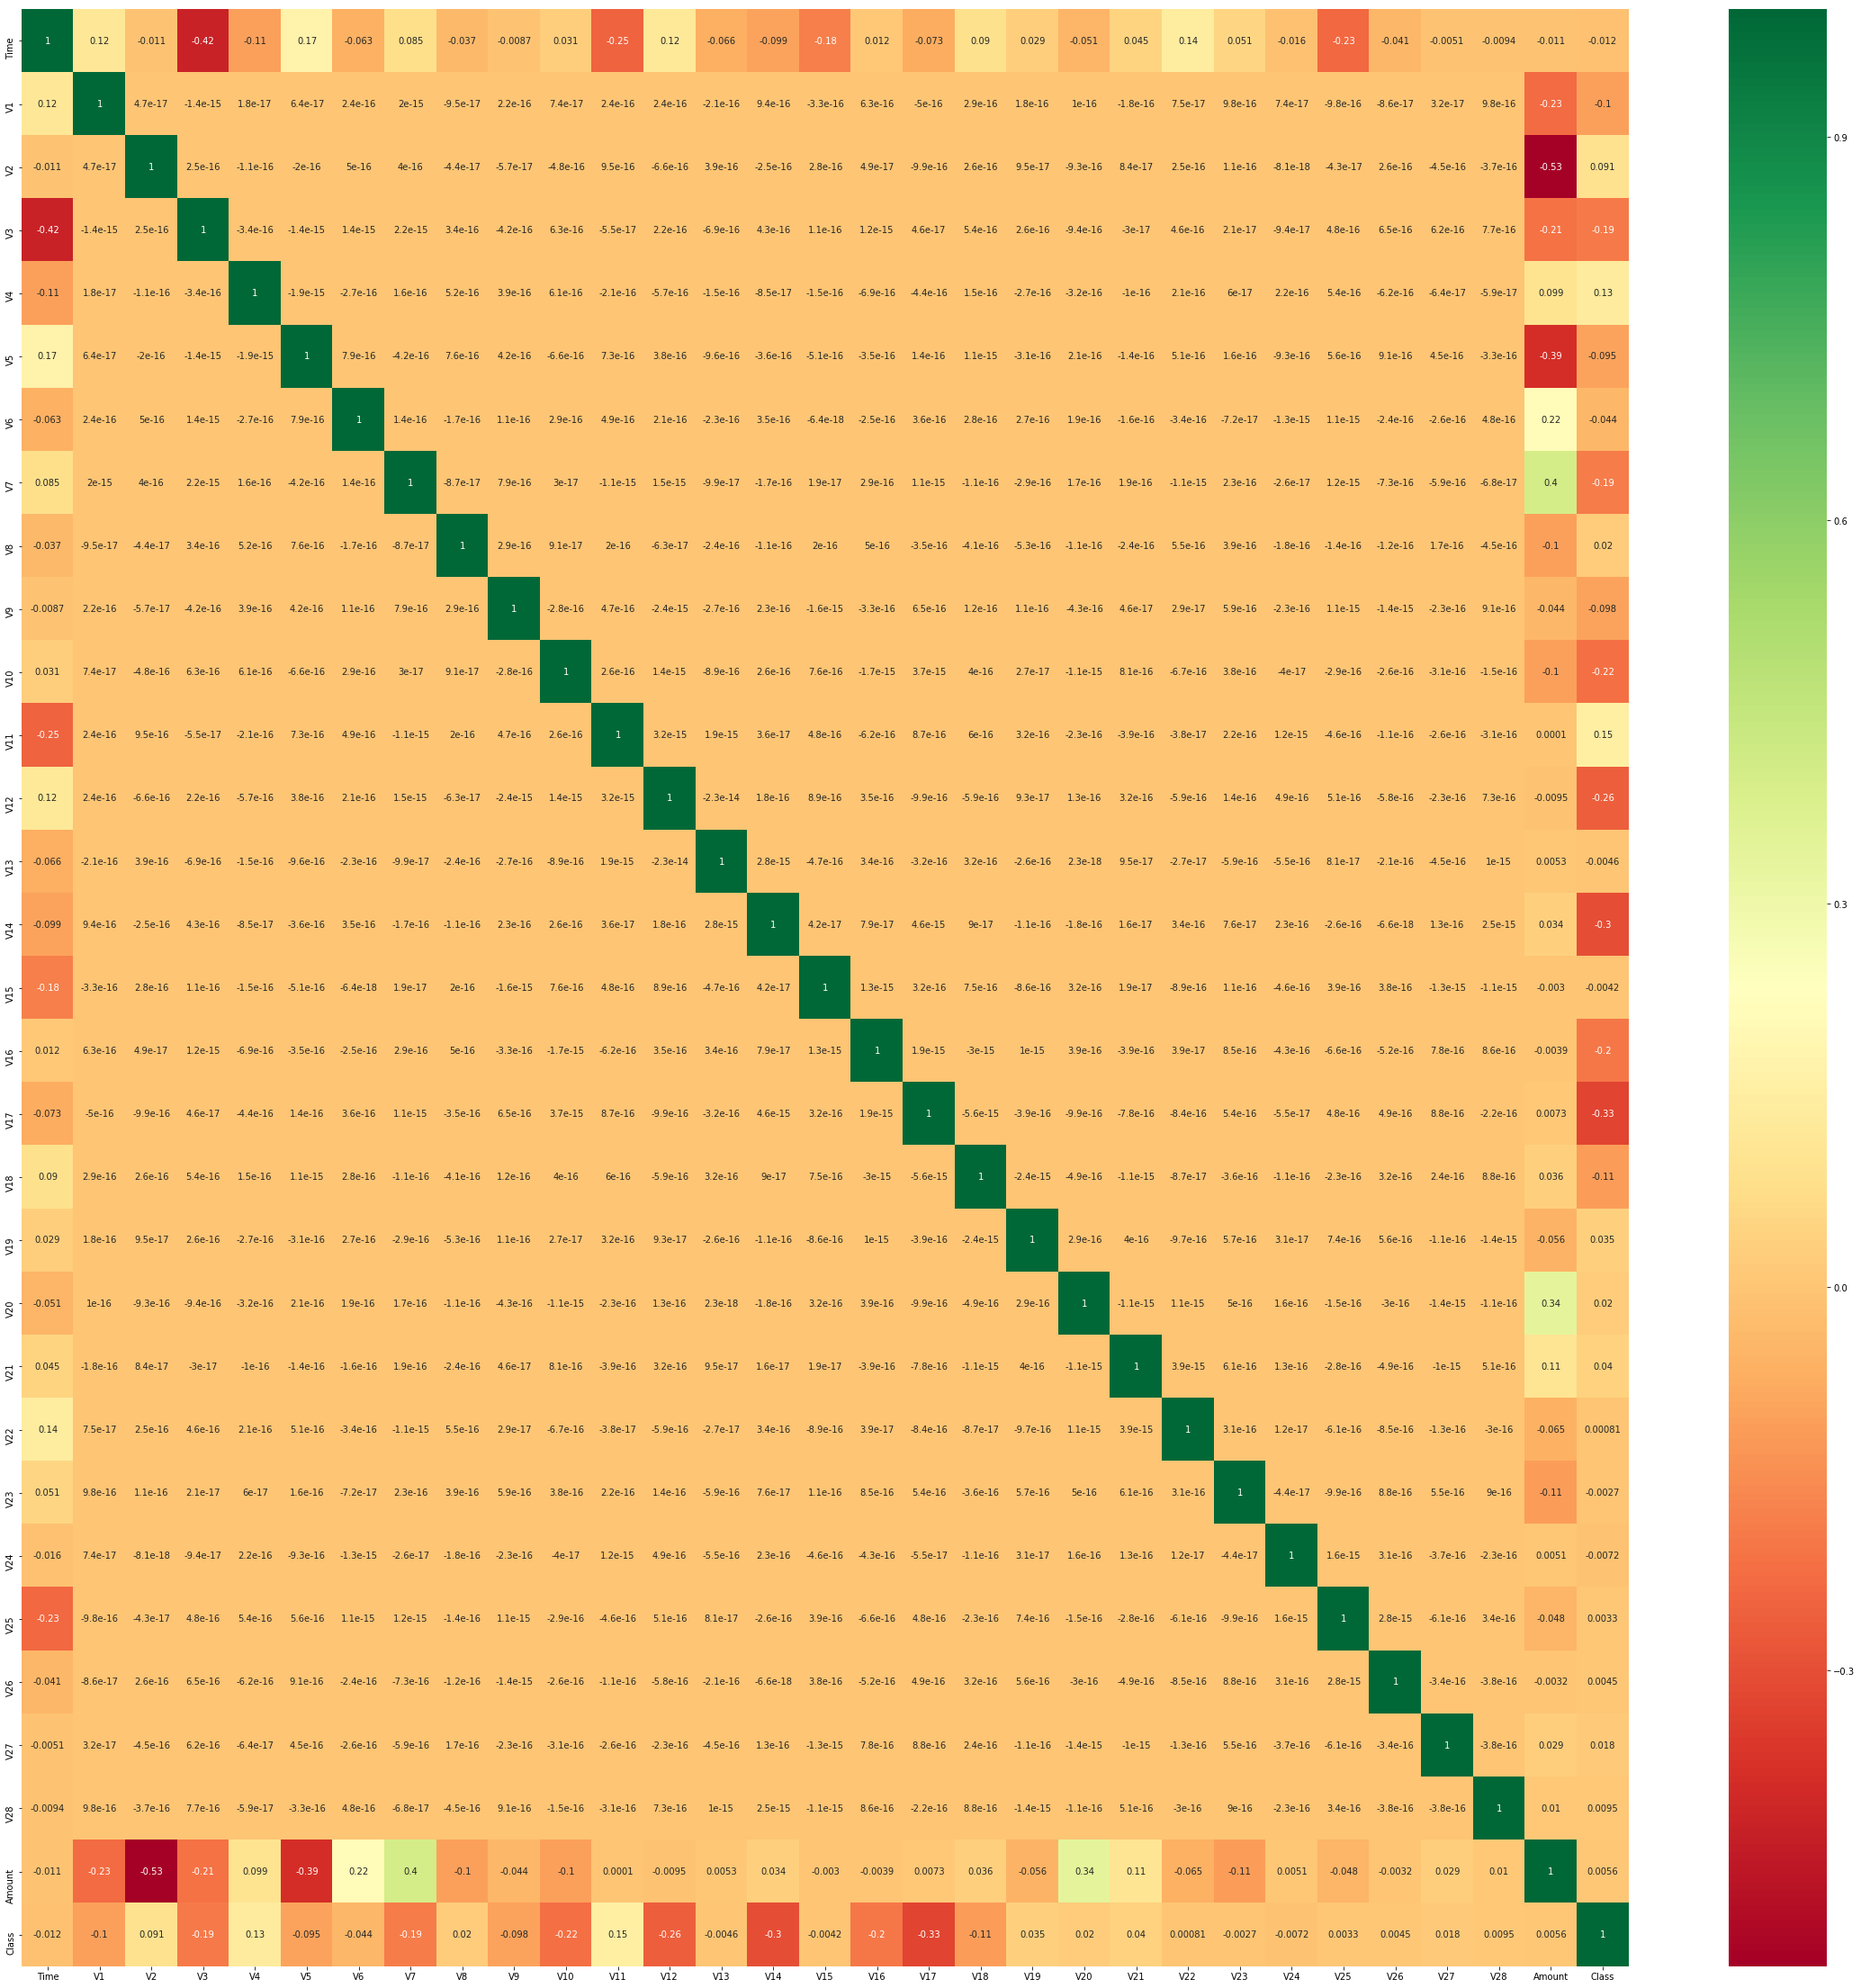

In [105]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,40))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [106]:
classes=data['Class']
data.drop(['Time', 'Class','Amount'], axis=1, inplace=True)

cols = data.columns
MMscaller = MinMaxScaler()
data = MMscaller.fit_transform(data)
data = pd.DataFrame(data=data, columns=cols)
data = pd.concat([data, classes], axis=1)


In [107]:
def train_validation_splits(df):
    fraud = df[df['Class'] == 1]
    normal = df[df['Class'] == 0]
    print('normal:', normal.shape[0])
    print('fraud:', fraud.shape[0])
    #print(normal)
    normal_test_start = int(normal.shape[0] * .2)
    fraud_test_start = int(fraud.shape[0] * .5)
    normal_train_start = normal_test_start * 2
    val_normal = normal[:normal_test_start]
    val_fraud = fraud[:fraud_test_start]
    validation_set = pd.concat([val_normal, val_fraud], axis=0)
    test_normal = normal[normal_test_start:normal_train_start]
    test_fraud = fraud[fraud_test_start:fraud.shape[0]]
    test_set = pd.concat([test_normal, test_fraud], axis=0)
    Xval = validation_set.iloc[:, :-1]
    Yval = validation_set.iloc[:, -1]
    Xtest = test_set.iloc[:, :-1]
    Ytest = test_set.iloc[:, -1]
    train_set = normal[normal_train_start:normal.shape[0]]
    Xtrain = train_set.iloc[:, :-1]
    return Xtrain.values, Xtest.values, Xval.values, Ytest.values, Yval.values

In [108]:
def estimate_gaussian_params(X):
    """
    Calculates the mean and the covariance for each feature.
    Arguments:
    X: dataset
    """
    mu = np.mean(X, axis=0)
    sigma = np.cov(X.T)
    return mu, sigma


In [109]:
(Xtrain, Xtest, Xval, Ytest, Yval) = train_validation_splits(data)
mu, sigma = estimate_gaussian_params(Xtrain)
# calculate gaussian pdf
p =multivariate_normal.pdf(Xtrain, mu, sigma)
pval = multivariate_normal.pdf(Xval, mu, sigma)
ptest = multivariate_normal.pdf(Xtest, mu, sigma)

normal: 284315
fraud: 492


array([3.29190305e+31, 2.17748799e+32, 1.51900907e+24, ...,
       0.00000000e+00, 7.54085104e+31, 8.21890765e+25])

In [110]:
def metrics(y, predictions):
    fp = np.sum(np.all([predictions == 1, y == 0], axis=0))
    tp = np.sum(np.all([predictions == 1, y == 1], axis=0))
    fn = np.sum(np.all([predictions == 0, y == 1], axis=0))
    precision = (tp / (tp + fp)) if (tp + fp) > 0 else 0
    recall = (tp / (tp + fn)) if (tp + fn) > 0 else 0
    F1 = (2 * precision * recall) / (precision +
                                     recall) if (precision + recall) > 0 else 0
    return precision, recall, F1
def selectThreshold(yval, pval):
    e_values = pval
    bestF1 = 0
    bestEpsilon = 0
    for epsilon in e_values:
        predictions = pval < epsilon
        (precision, recall, F1) = metrics(yval, predictions)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

In [111]:
(epsilon, F1) = selectThreshold(Yval, pval)
print("Best epsilon found:", epsilon)
print("Best F1 on cross validation set:", F1)
(test_precision, test_recall, test_F1) = metrics(Ytest, ptest < epsilon)
print("Outliers found:", np.sum(ptest < epsilon))
print("Test set Precision:", test_precision)
print("Test set Recall:", test_recall)
print("Test set F1 score:", test_F1)


Best epsilon found: 5e-324
Best F1 on cross validation set: 0.7852998065764023
Outliers found: 210
Test set Precision: 0.9095238095238095
Test set Recall: 0.7764227642276422
Test set F1 score: 0.837719298245614
